In [1]:
import warnings
warnings.filterwarnings("ignore")


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import numpy as np
import gym
from tqdm import tqdm

import matplotlib.pyplot as plt
import collections
import random


In [2]:
device = "cpu"

LEARNING_RATE = 1e-4
BUFFER_MAX_SIZE = 1000000
BUFFER_MIN_SIZE = 320
LEARNING_TIME = 500000
GAMMA = 0.99

MINI_BATCH_SIZE = 64
UPDATE_TIME_STAMP = 15

epsilon = 0.9
MIN_EPSILON = 0.1
DECAY = (epsilon - MIN_EPSILON) / 100000

INTERVAL = 10000


In [3]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc = F.relu):
        super(DQN, self).__init__()
        self.activation_fc = activation_fc
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
            
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x).to(device)
            x = x.unsqueeze(0)
        
        x = self.activation_fc(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation_fc(layer(x))
        x = self.output_layer(x)
        return x
        

In [4]:
env = gym.make('LunarLander-v2')
state, _ = env.reset()
train_model = DQN(len(state), env.action_space.n, (128, 256, 512)).to(device)
target_model = DQN(len(state), env.action_space.n, (128, 256, 512)).to(device)

target_model.load_state_dict(train_model.state_dict())

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(train_model.parameters(), lr=LEARNING_RATE)

replay_buffer = collections.deque(maxlen=BUFFER_MAX_SIZE)



In [5]:
def eval(render):
    eval_env = gym.make('LunarLander-v2', render_mode="human" if render else None)
    with torch.no_grad():
        eval_dqn = torch.load("model.pth")
        EVAL_EPISODES = 5
        eval_rewards_total = []
        for episode in range(EVAL_EPISODES):
            state, _ = eval_env.reset()
            eval_rewards = []
            done = False
            while not done:
                action_values = eval_dqn(state)
                action = int(torch.argmax(action_values.squeeze()))
                next_state, reward, terminated, truncated , info = eval_env.step(action)
                if render:
                    eval_env.render()
                done = terminated or truncated
                
                eval_rewards.append(reward)
                state = next_state

            eval_rewards_total.append(np.sum(eval_rewards))

    plt.scatter(range(len(eval_rewards_total)), eval_rewards_total)
    plt.xlabel("Episode")
    plt.ylabel("Total Time Survived")
    plt.show()
    _ = env.reset()  

    print(f"Average Reward: {np.mean(eval_rewards_total)}")    
            

  2%|▏         | 9994/500000 [01:01<59:43, 136.73it/s]  

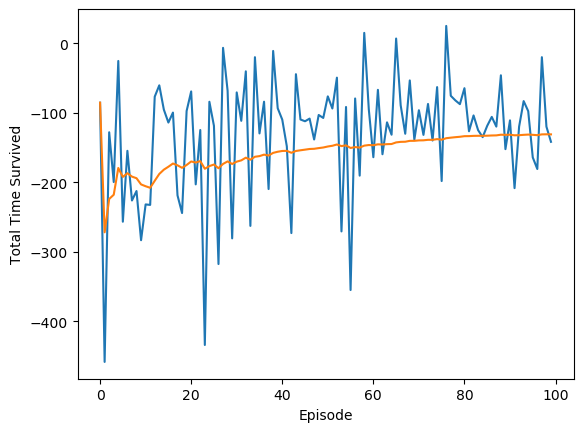

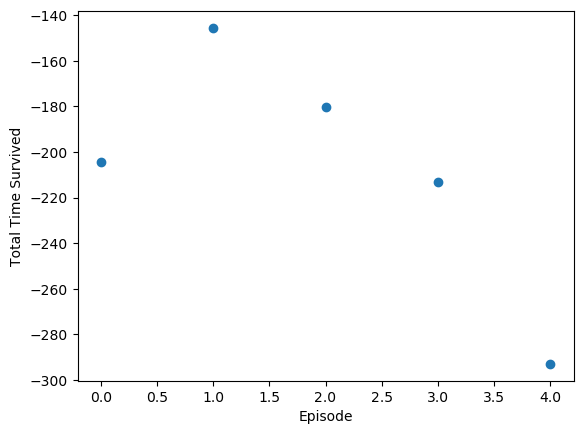

  2%|▏         | 10020/500000 [01:05<7:47:27, 17.47it/s] 

Average Reward: -207.12892114065266


  4%|▍         | 19991/500000 [02:17<57:50, 138.32it/s]  

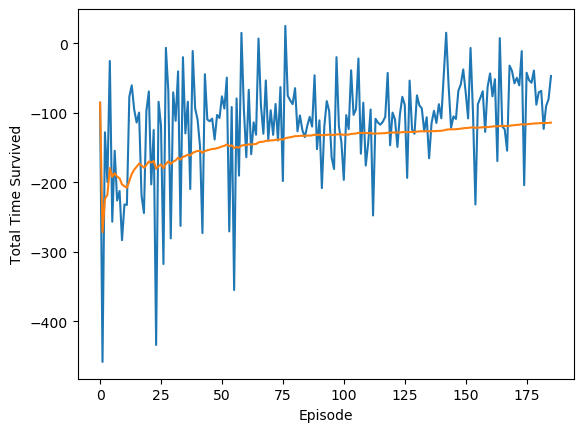

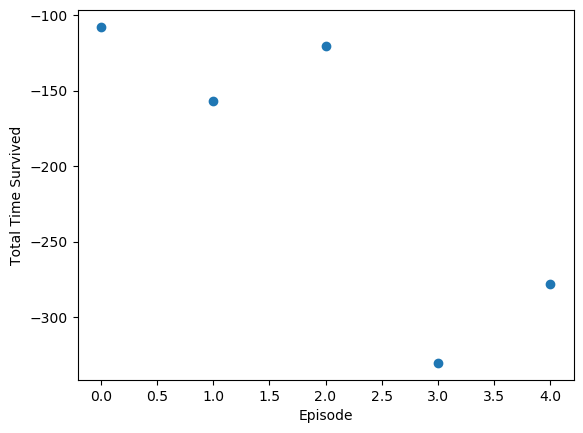

  4%|▍         | 20019/500000 [02:28<21:36:35,  6.17it/s]

Average Reward: -198.6369334661165


  6%|▌         | 29996/500000 [03:39<1:07:24, 116.22it/s]

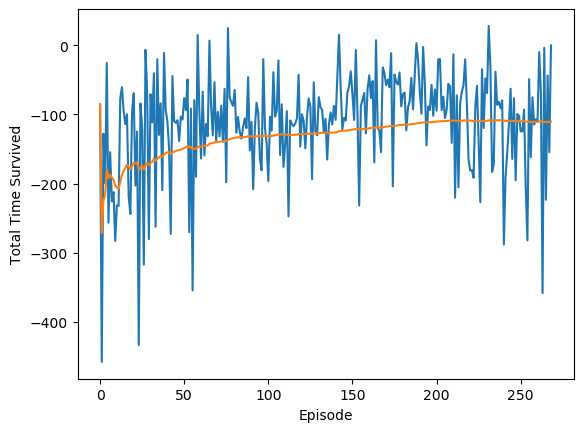

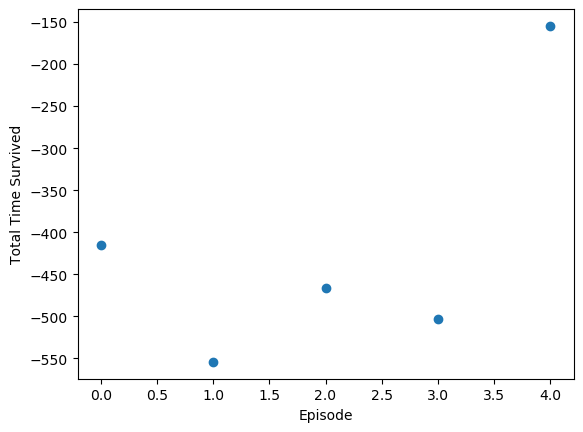

  6%|▌         | 30021/500000 [03:44<10:35:00, 12.34it/s]

Average Reward: -418.53414186489556


  8%|▊         | 39996/500000 [04:59<54:15, 141.32it/s]  

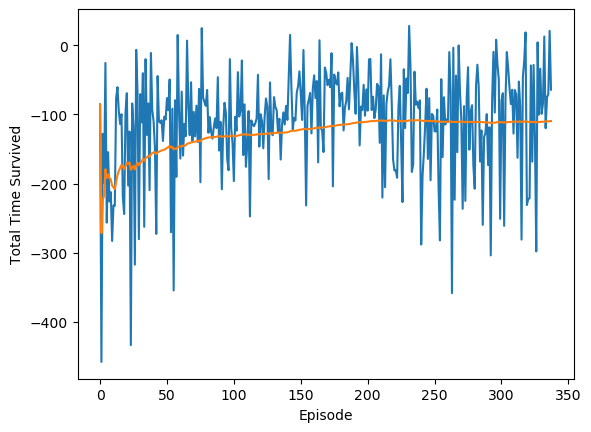

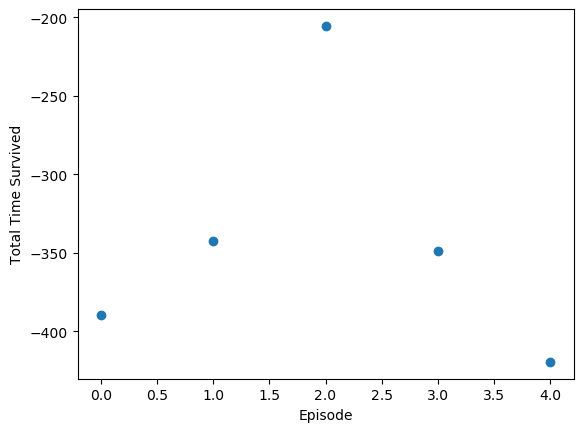

  8%|▊         | 40011/500000 [05:03<11:11:38, 11.41it/s]

Average Reward: -341.26569993832544


 10%|▉         | 49993/500000 [06:19<59:58, 125.04it/s]  

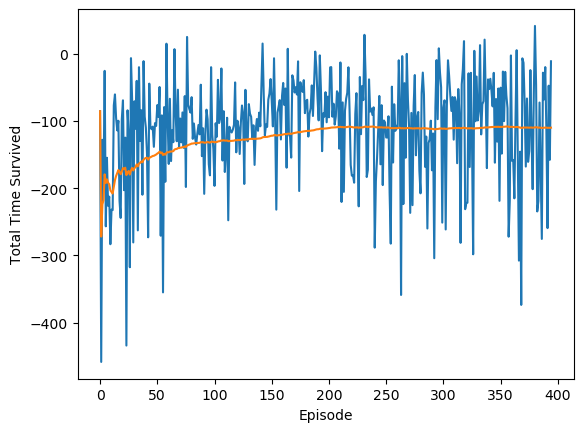

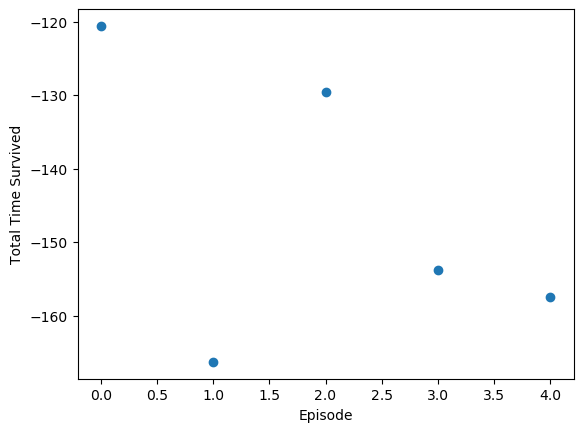

 10%|█         | 50017/500000 [06:22<6:26:21, 19.41it/s]

Average Reward: -145.5507620792702


 12%|█▏        | 59997/500000 [07:48<1:06:55, 109.57it/s]

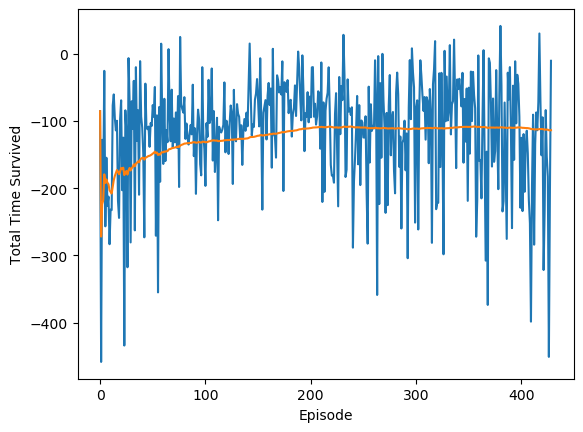

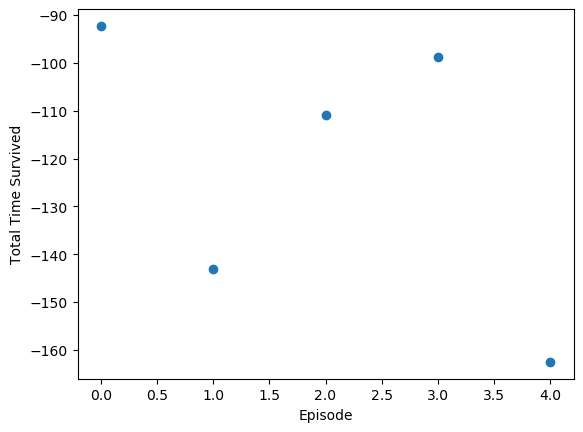

 12%|█▏        | 60027/500000 [07:59<21:26:22,  5.70it/s]

Average Reward: -121.51189770869514


 14%|█▍        | 69989/500000 [09:40<59:39, 120.12it/s]  

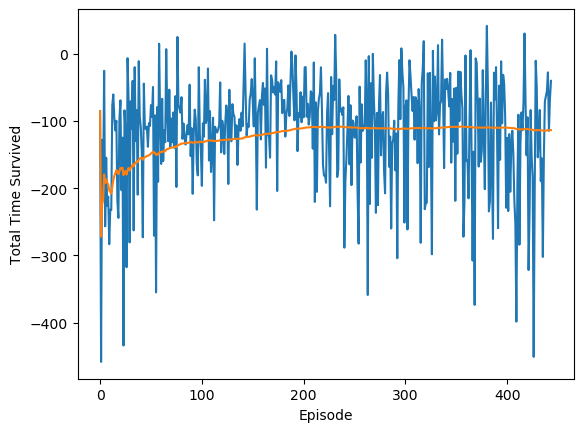

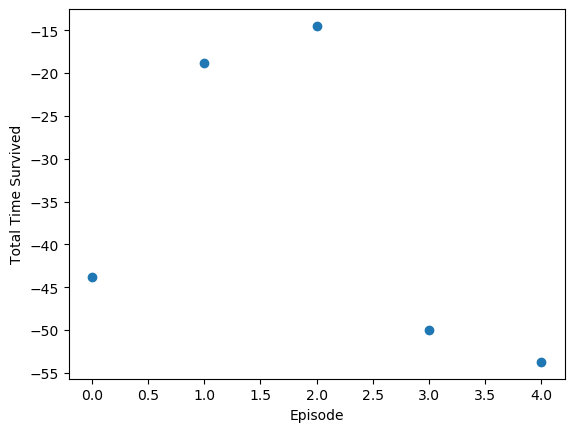

 14%|█▍        | 70014/500000 [09:55<30:35:10,  3.91it/s]

Average Reward: -36.16372196148088


 16%|█▌        | 79999/500000 [11:46<1:32:22, 75.78it/s] 

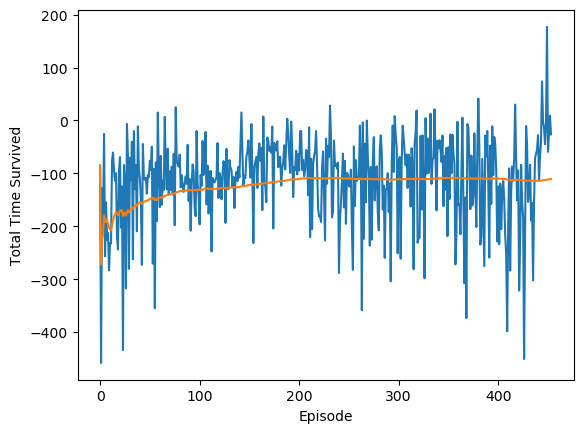

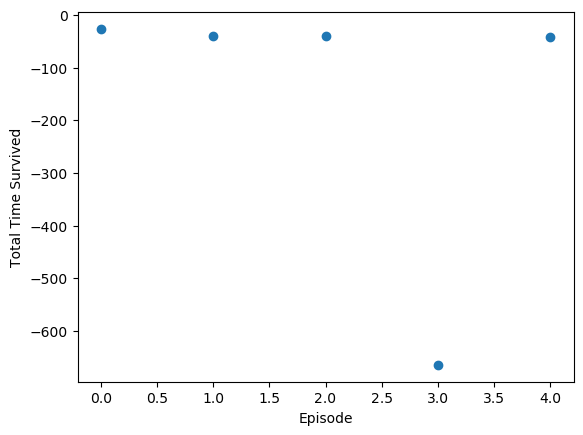

 16%|█▌        | 80017/500000 [11:57<31:42:32,  3.68it/s]

Average Reward: -162.61815527500818


 18%|█▊        | 89995/500000 [13:48<1:19:12, 86.27it/s] 

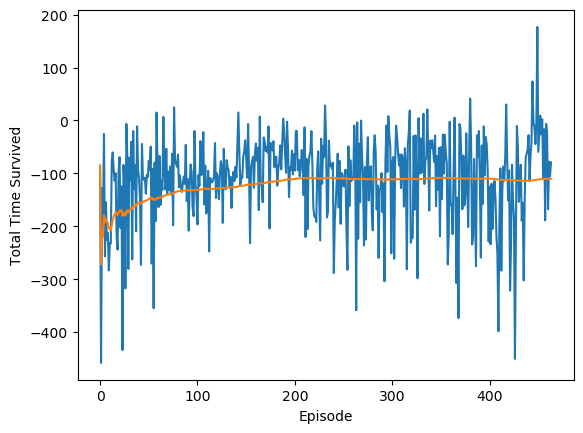

 18%|█▊        | 89995/500000 [14:00<1:19:12, 86.27it/s]

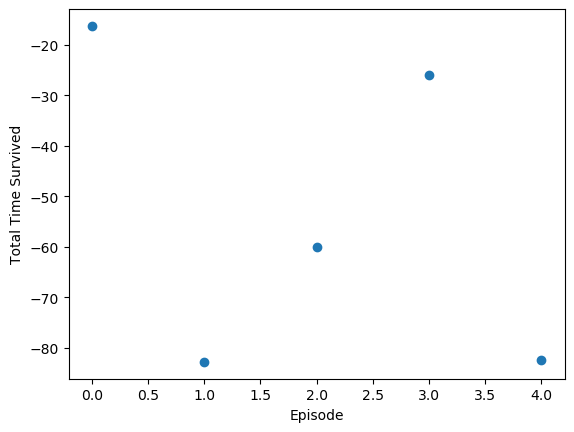

 18%|█▊        | 90011/500000 [14:05<48:11:24,  2.36it/s]

Average Reward: -53.49956636165509


 20%|█▉        | 99991/500000 [15:59<1:23:05, 80.23it/s] 

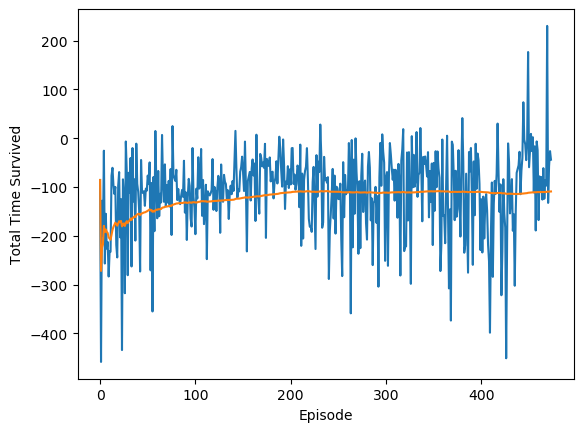

 20%|█▉        | 99991/500000 [16:10<1:23:05, 80.23it/s]

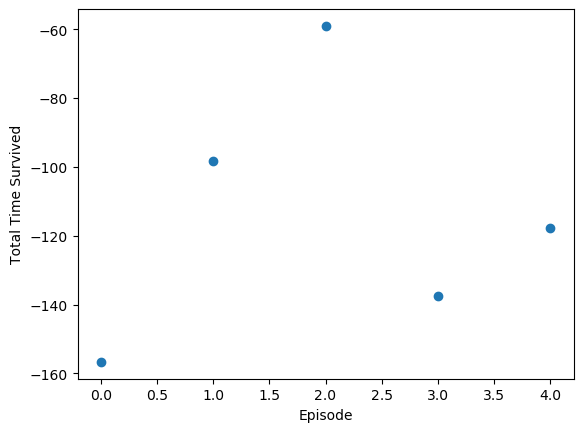

 20%|██        | 100016/500000 [16:12<28:26:03,  3.91it/s]

Average Reward: -113.82580078954615


 22%|██▏       | 109997/500000 [18:03<1:12:40, 89.43it/s] 

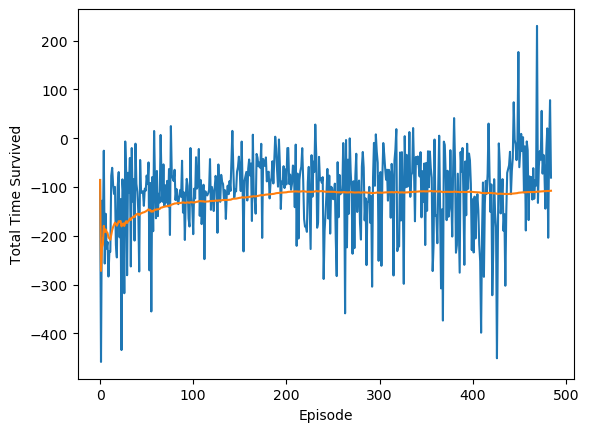

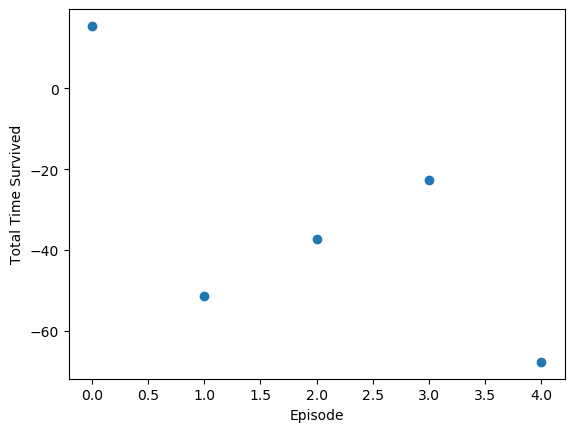

 22%|██▏       | 110023/500000 [18:16<27:10:27,  3.99it/s]

Average Reward: -32.73678448875514


 24%|██▍       | 119995/500000 [20:10<1:24:03, 75.35it/s] 

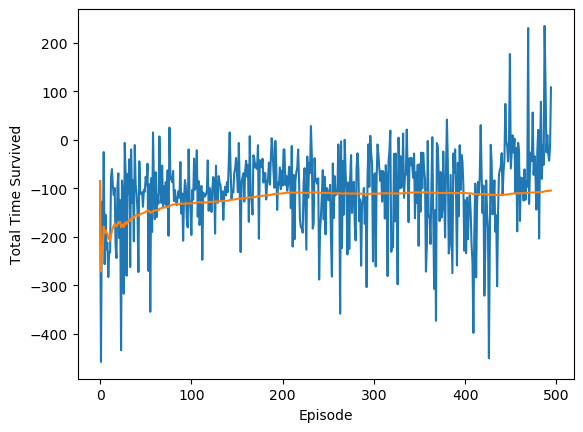

 24%|██▍       | 119995/500000 [20:20<1:24:03, 75.35it/s]

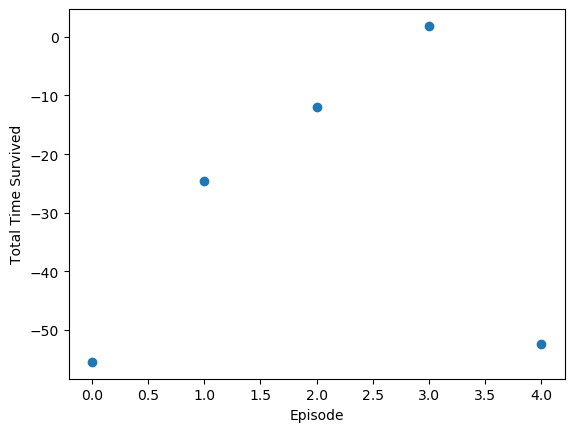

 24%|██▍       | 120011/500000 [20:24<39:59:34,  2.64it/s]

Average Reward: -28.516617608687852


 26%|██▌       | 129994/500000 [22:14<1:13:28, 83.93it/s] 

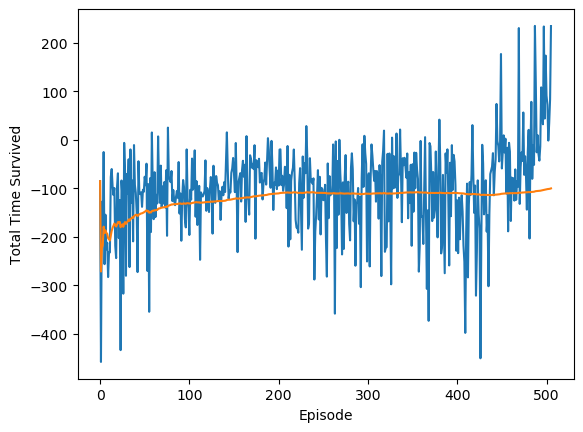

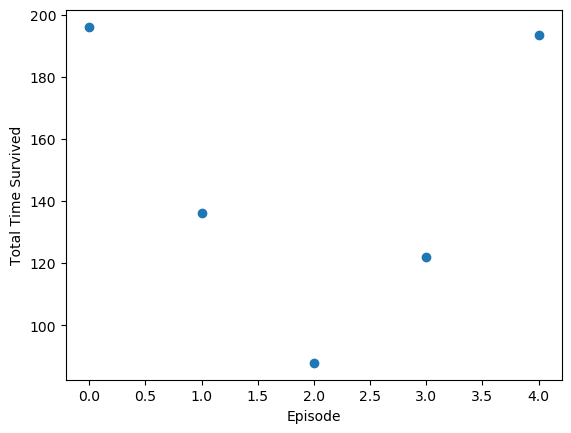

 26%|██▌       | 130013/500000 [22:20<15:05:24,  6.81it/s]

Average Reward: 147.17582758881775


 28%|██▊       | 139990/500000 [24:02<54:59, 109.10it/s]  

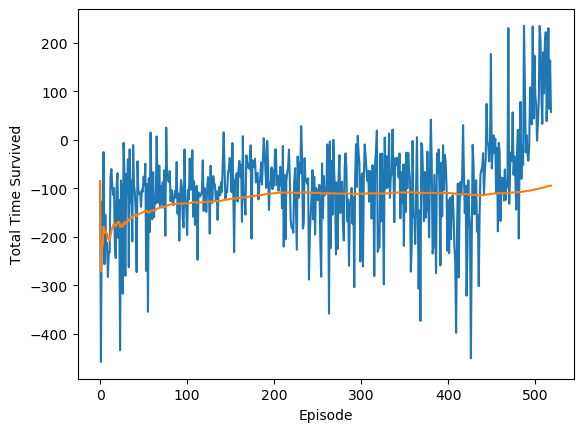

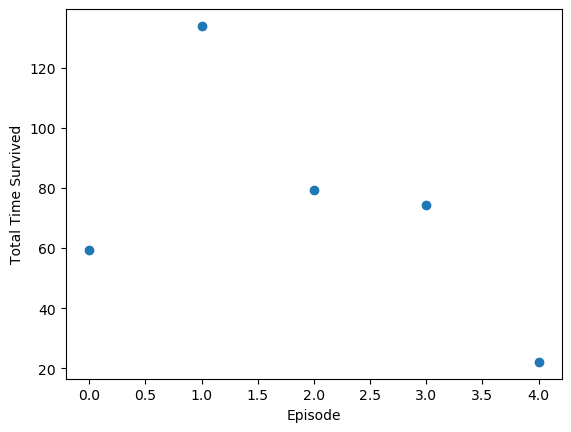

 28%|██▊       | 140012/500000 [24:18<28:54:49,  3.46it/s]

Average Reward: 73.80312850522243


 30%|██▉       | 149994/500000 [25:59<31:27, 185.46it/s]  

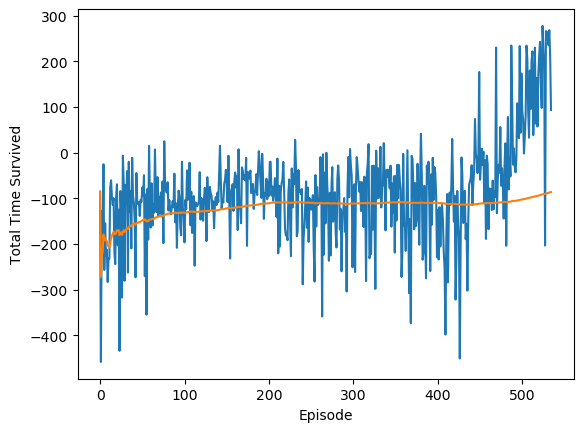

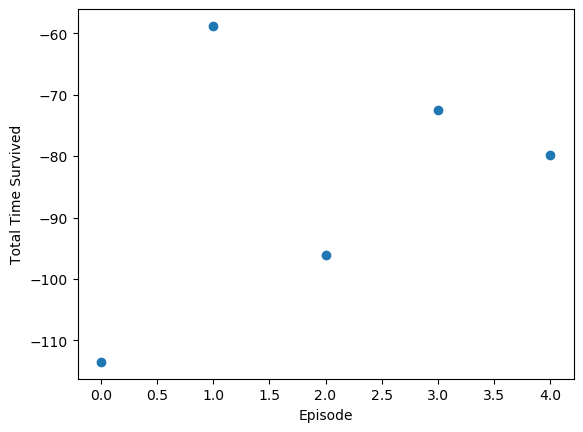

 30%|███       | 150013/500000 [26:09<15:33:36,  6.25it/s]

Average Reward: -84.14289371628654


 32%|███▏      | 159992/500000 [27:54<33:47, 167.67it/s]  

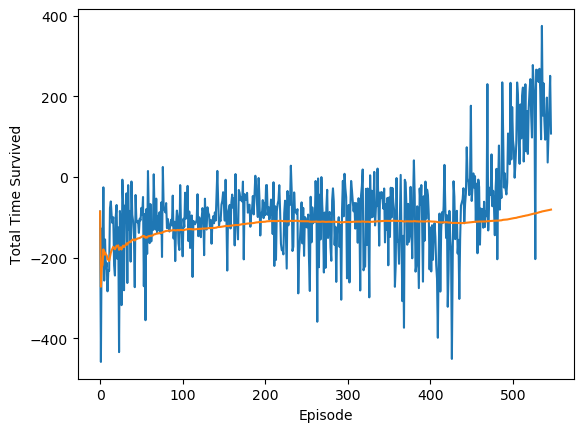

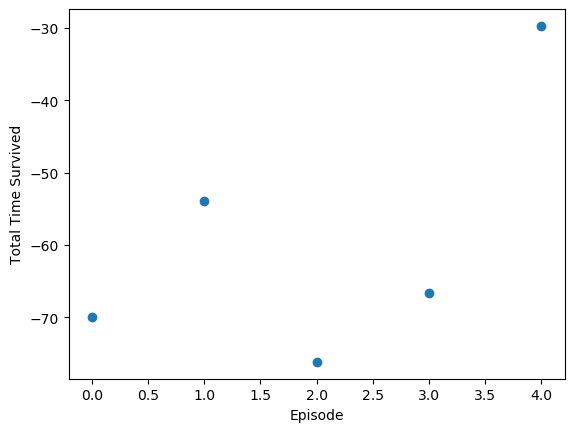

 32%|███▏      | 160018/500000 [28:06<17:33:19,  5.38it/s]

Average Reward: -59.308785193500604


 34%|███▍      | 169998/500000 [29:53<37:39, 146.05it/s]  

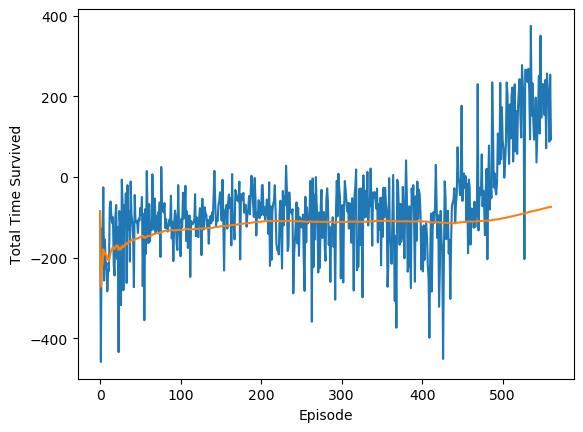

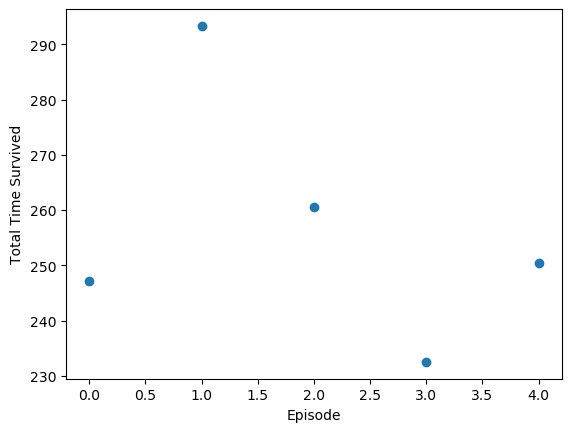

 34%|███▍      | 170013/500000 [29:54<2:23:24, 38.35it/s]

Average Reward: 256.7709628518357


 36%|███▌      | 179995/500000 [31:40<1:00:21, 88.36it/s]

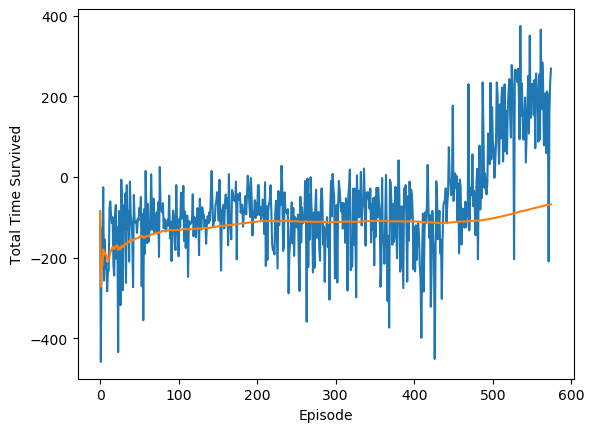

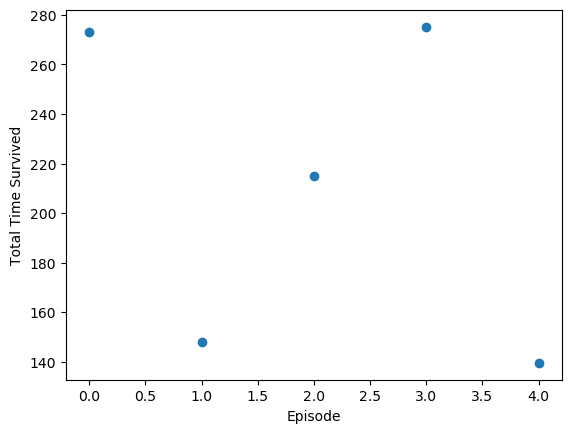

 36%|███▌      | 180022/500000 [31:48<13:23:52,  6.63it/s]

Average Reward: 210.2484878619376


 38%|███▊      | 189997/500000 [33:37<1:02:13, 83.03it/s] 

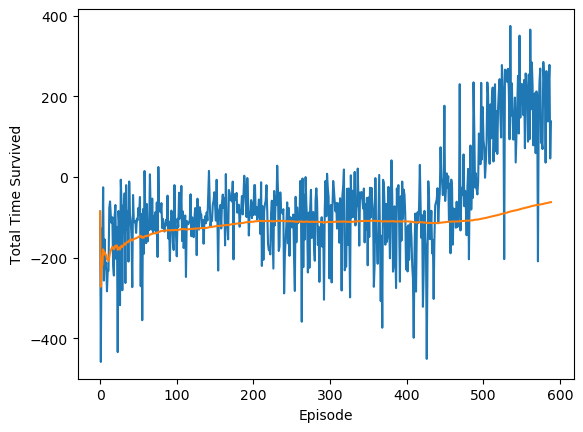

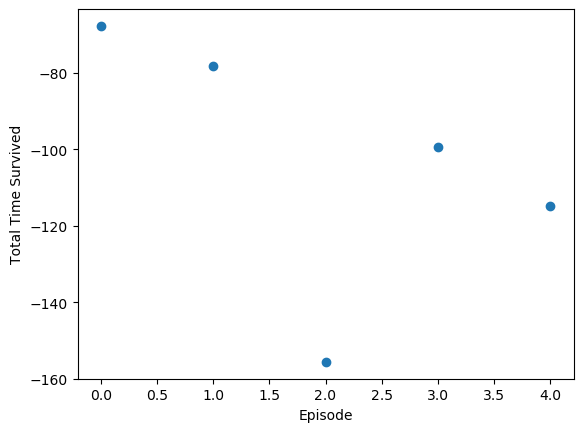

 38%|███▊      | 190016/500000 [33:47<21:13:56,  4.06it/s]

Average Reward: -103.16179022133778


 40%|███▉      | 199995/500000 [35:37<55:52, 89.49it/s]   

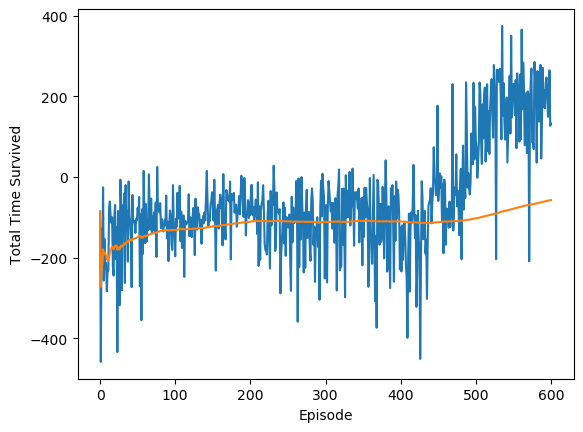

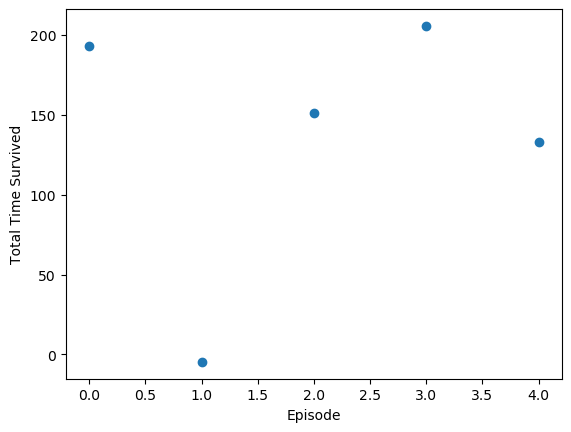

 40%|████      | 200019/500000 [35:44<12:38:21,  6.59it/s]

Average Reward: 135.6962806495057


 42%|████▏     | 209994/500000 [37:30<51:19, 94.18it/s]   

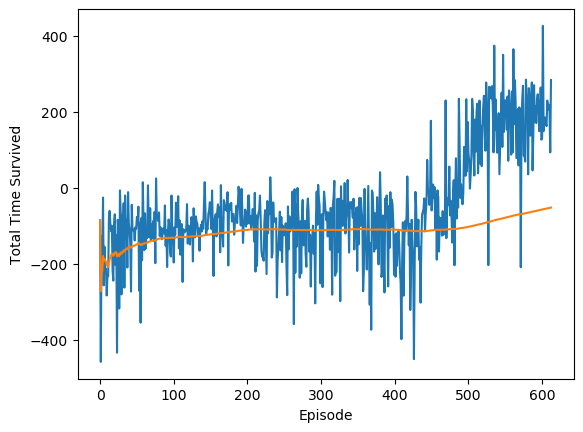

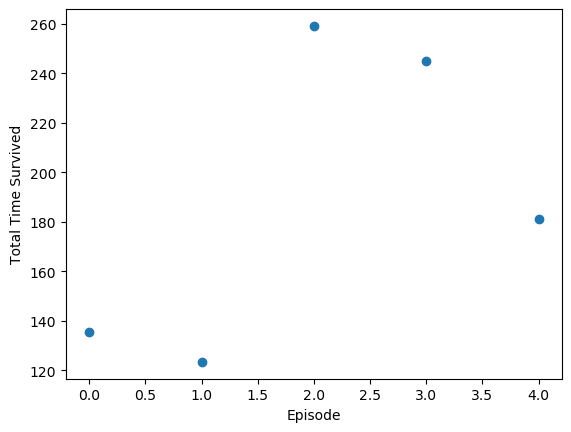

 42%|████▏     | 210011/500000 [37:35<10:48:09,  7.46it/s]

Average Reward: 188.86777270118574


 44%|████▍     | 219989/500000 [39:22<46:33, 100.22it/s]  

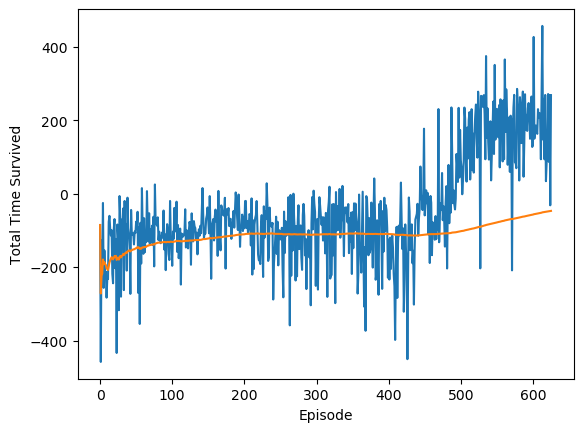

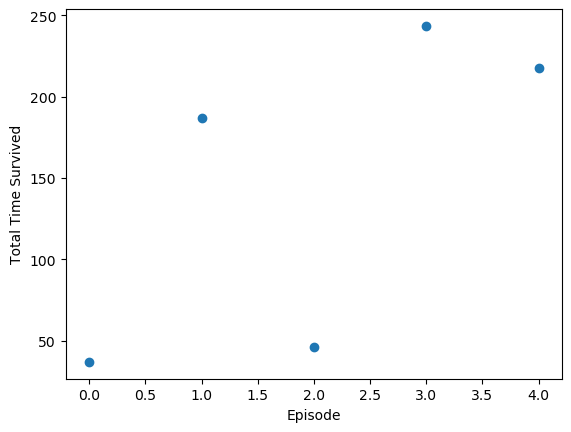

 44%|████▍     | 220008/500000 [39:32<15:47:56,  4.92it/s]

Average Reward: 146.26734163050244


 46%|████▌     | 229997/500000 [41:17<49:55, 90.14it/s]   

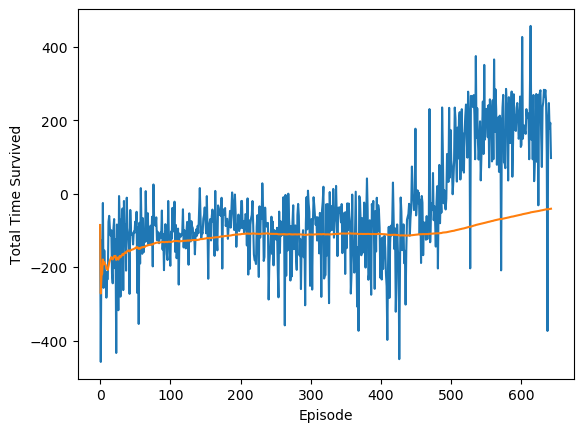

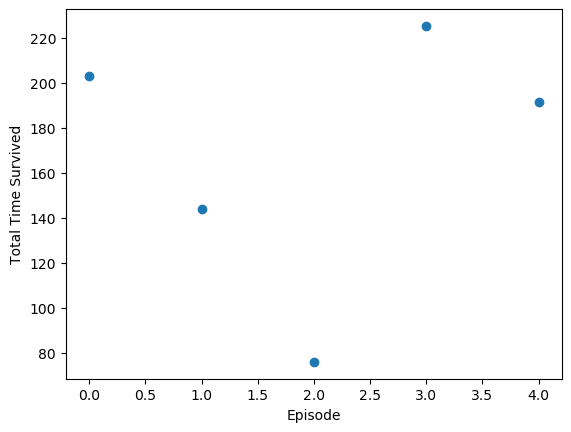

 46%|████▌     | 230016/500000 [41:25<12:42:53,  5.90it/s]

Average Reward: 167.89603029987381


 48%|████▊     | 239996/500000 [43:17<58:39, 73.88it/s]   

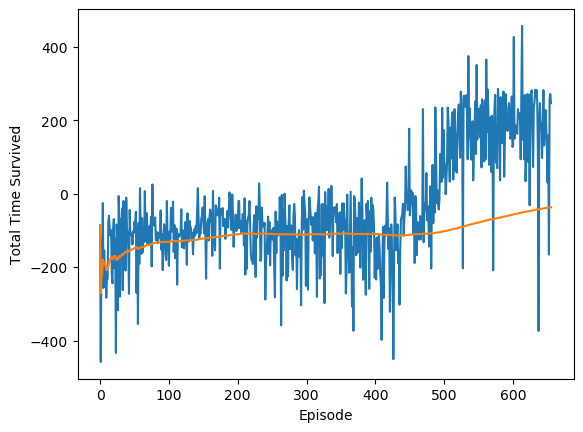

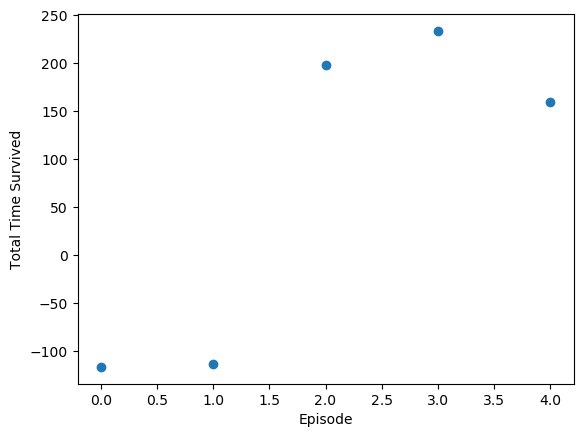

 48%|████▊     | 240021/500000 [43:26<13:47:20,  5.24it/s]

Average Reward: 72.07164013970305


 50%|████▉     | 249993/500000 [45:16<48:45, 85.46it/s]   

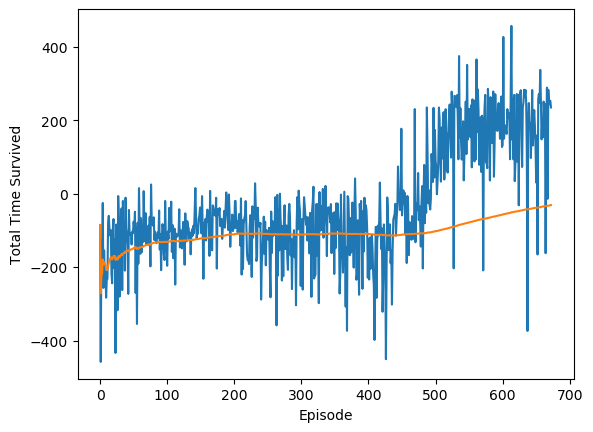

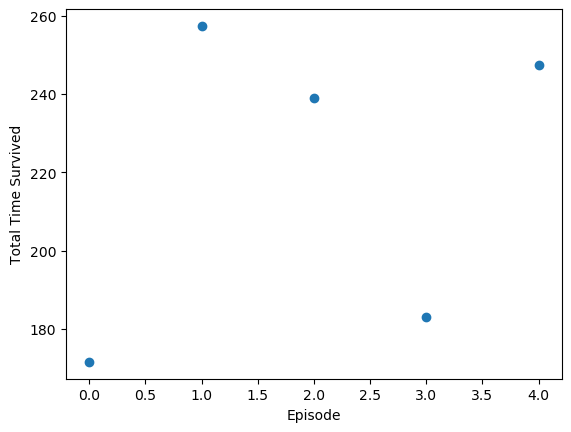

 50%|█████     | 250011/500000 [45:20<6:11:25, 11.22it/s]

Average Reward: 219.6867422562497


 52%|█████▏    | 259999/500000 [47:07<41:22, 96.67it/s]  

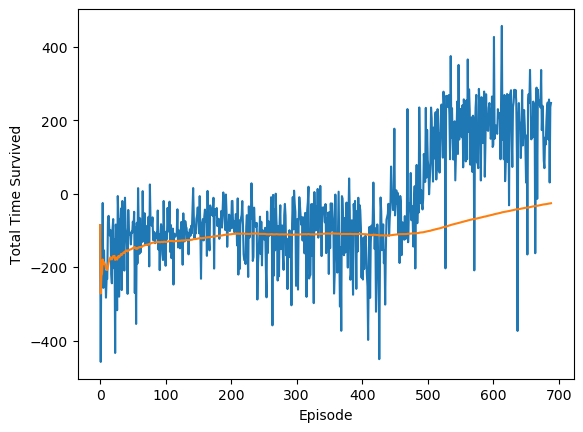

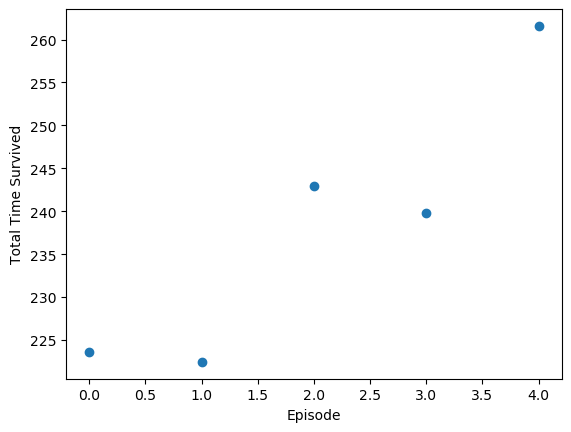

 52%|█████▏    | 260009/500000 [47:11<8:03:45,  8.27it/s]

Average Reward: 238.08970919901913


 54%|█████▍    | 269990/500000 [48:58<41:42, 91.92it/s]  

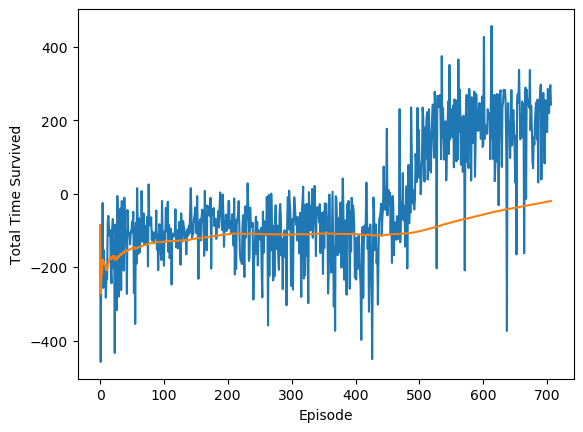

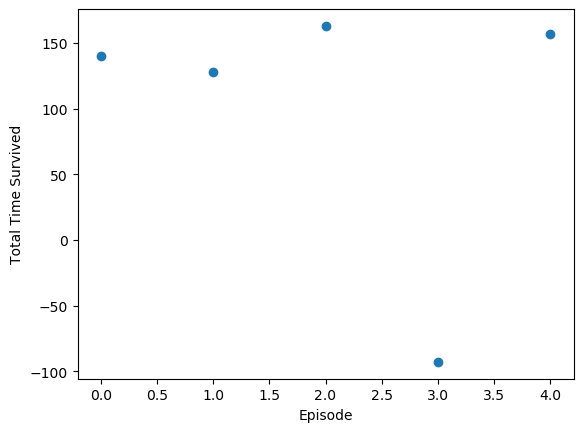

 54%|█████▍    | 270008/500000 [49:09<17:13:10,  3.71it/s]

Average Reward: 99.05192265175722


 56%|█████▌    | 279996/500000 [50:55<41:22, 88.62it/s]   

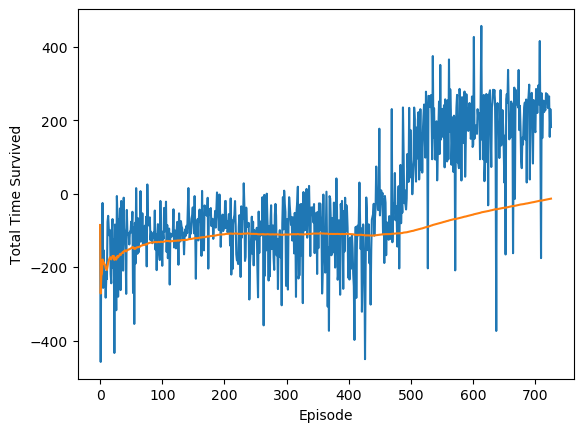

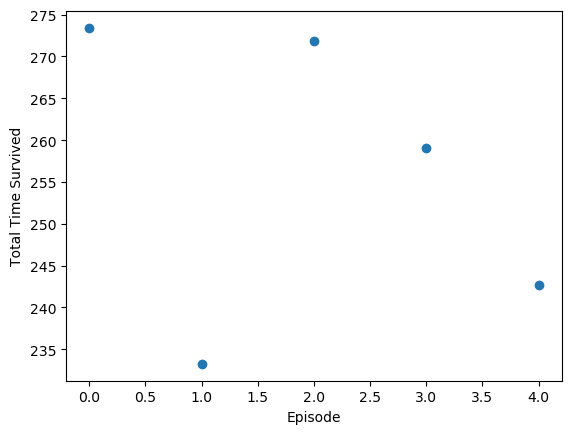

 56%|█████▌    | 280014/500000 [50:59<5:07:11, 11.94it/s]

Average Reward: 256.0612073250142


 58%|█████▊    | 289990/500000 [52:54<36:46, 95.19it/s]  

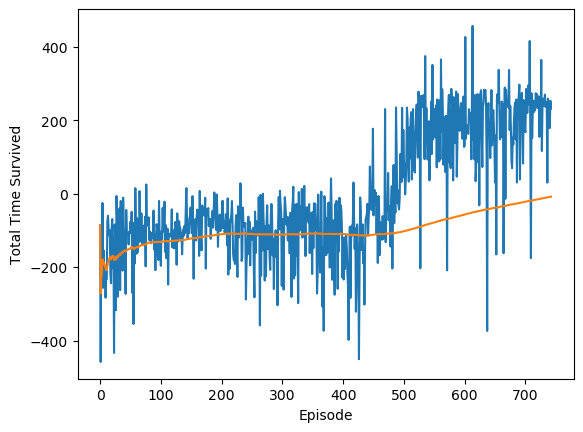

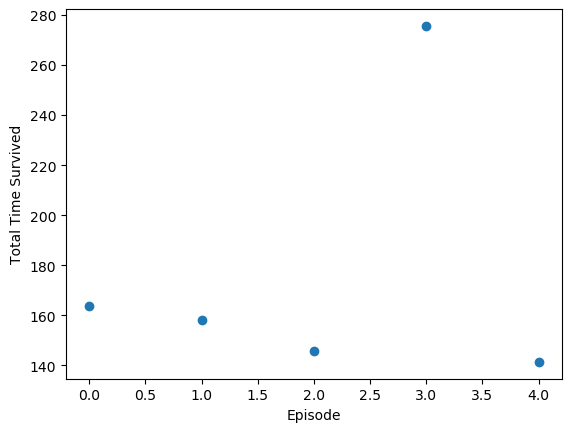

 58%|█████▊    | 290015/500000 [52:58<4:51:57, 11.99it/s]

Average Reward: 176.91454117611653


 60%|█████▉    | 299993/500000 [54:52<40:17, 82.72it/s]  

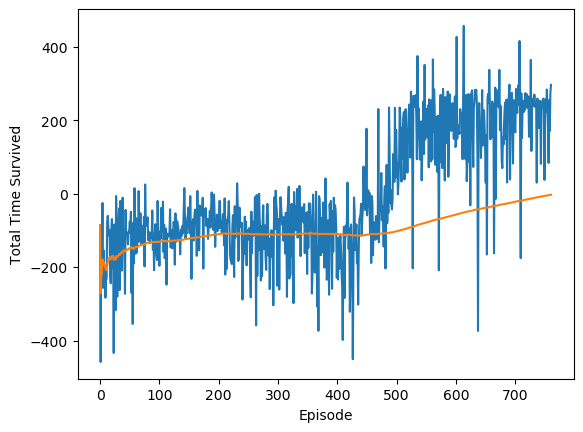

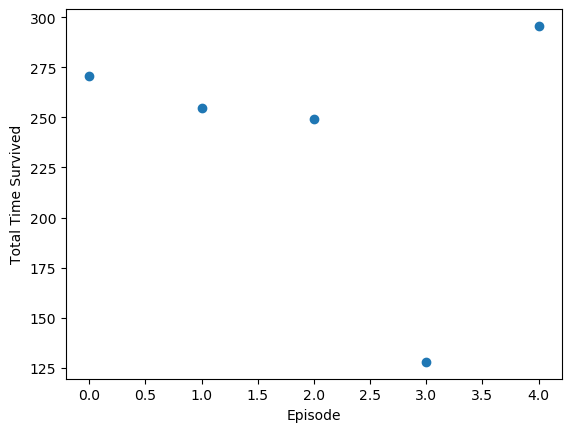

 60%|██████    | 300010/500000 [54:56<5:24:30, 10.27it/s]

Average Reward: 239.64234280790401


 62%|██████▏   | 309996/500000 [56:46<32:55, 96.17it/s]  

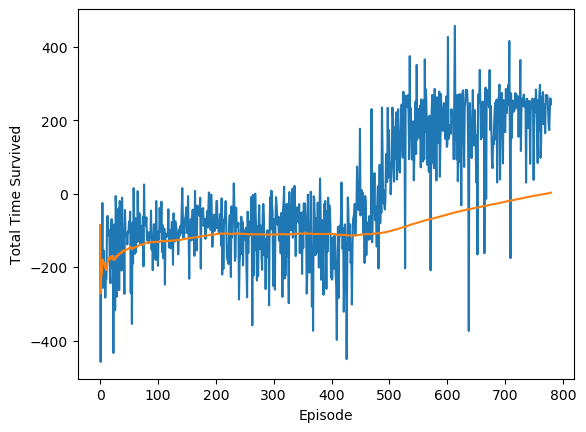

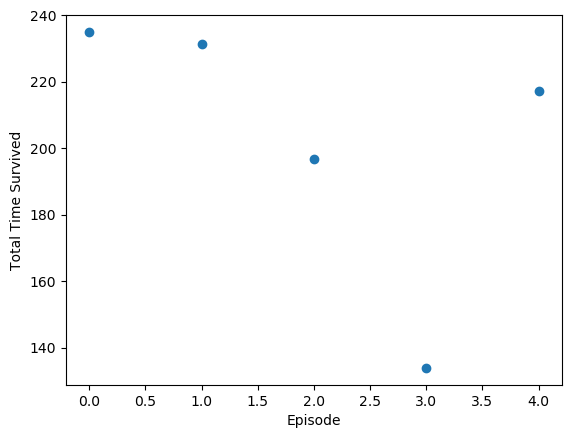

 62%|██████▏   | 310014/500000 [56:51<6:38:28,  7.95it/s]

Average Reward: 202.80792502833646


 64%|██████▍   | 319991/500000 [58:44<34:32, 86.85it/s]  

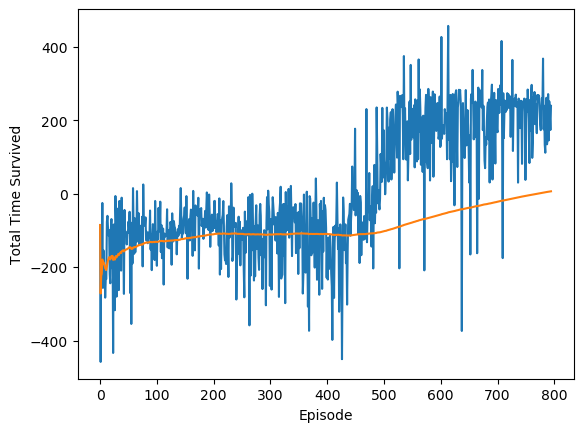

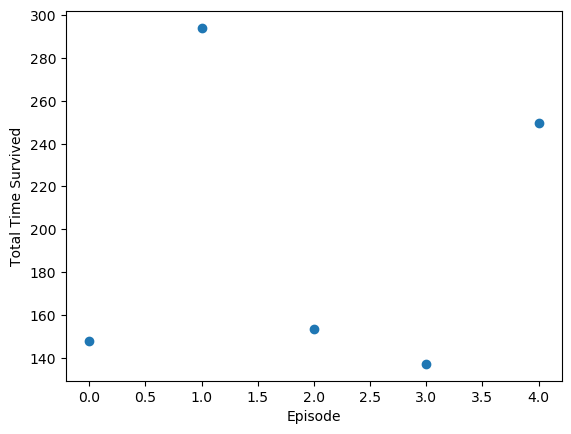

 64%|██████▍   | 320008/500000 [58:52<9:30:18,  5.26it/s] 

Average Reward: 196.4784709976406


 66%|██████▌   | 329997/500000 [1:00:50<36:08, 78.40it/s]

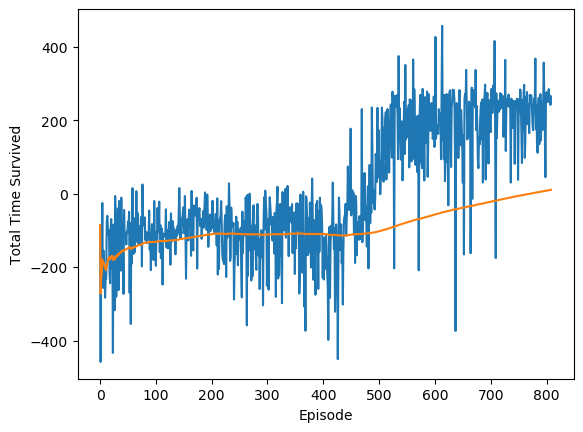

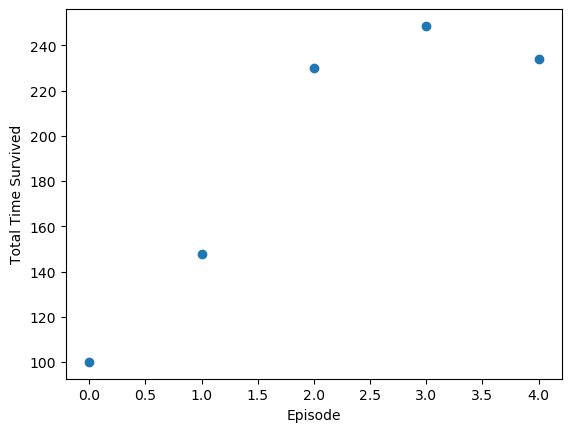

 66%|██████▌   | 330020/500000 [1:00:55<5:32:22,  8.52it/s]

Average Reward: 192.09967012536774


 68%|██████▊   | 339997/500000 [1:02:46<30:25, 87.63it/s]  

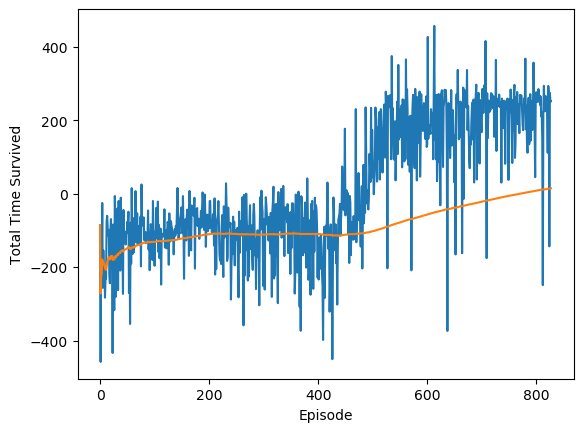

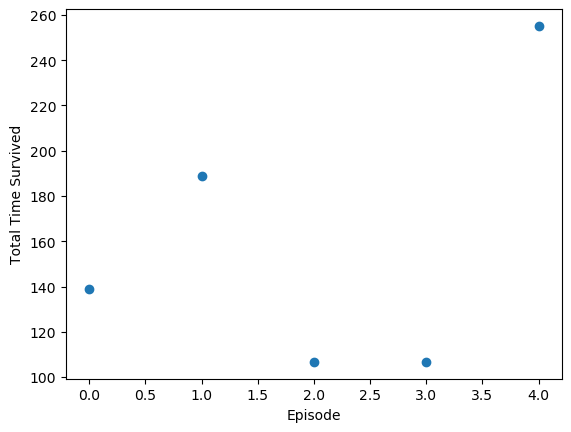

 68%|██████▊   | 340021/500000 [1:02:56<8:37:44,  5.15it/s] 

Average Reward: 159.327551483254


 70%|██████▉   | 349995/500000 [1:04:48<29:30, 84.70it/s]  

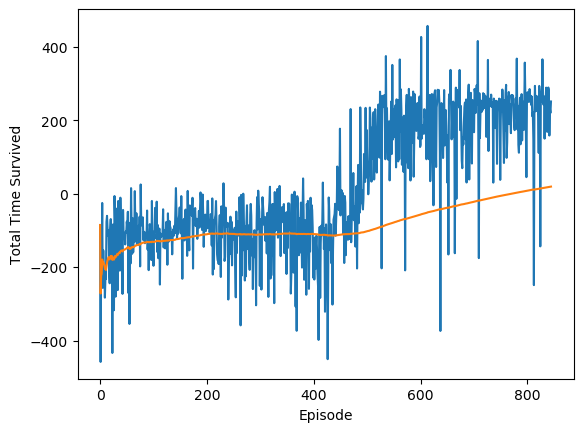

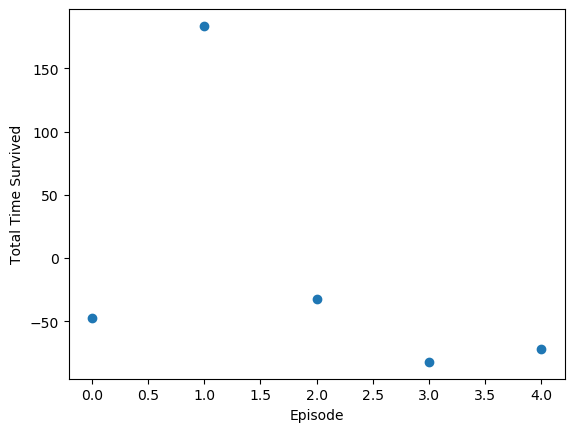

 70%|███████   | 350020/500000 [1:04:59<8:22:27,  4.97it/s] 

Average Reward: -10.099137018592334


 72%|███████▏  | 359999/500000 [1:06:54<27:33, 84.68it/s]  

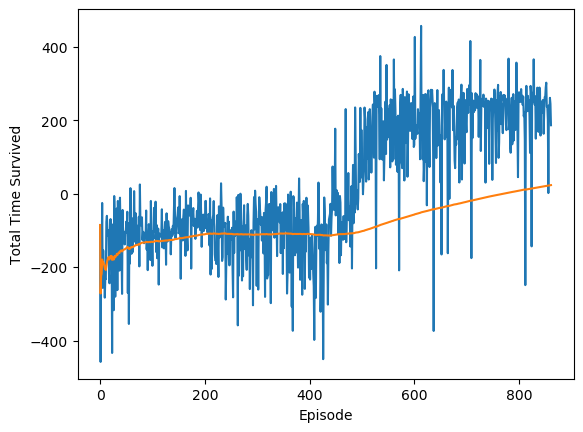

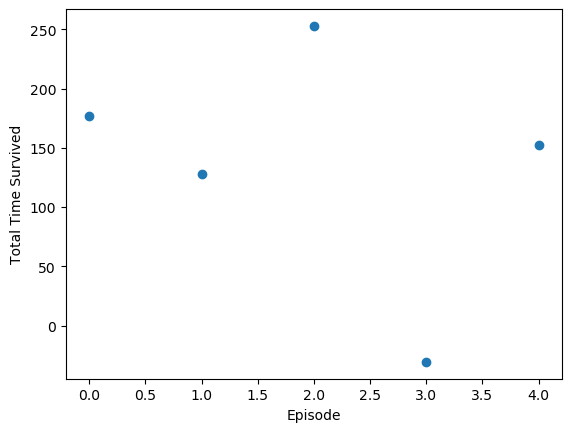

 72%|███████▏  | 360008/500000 [1:07:00<8:12:02,  4.74it/s]

Average Reward: 136.00438087591246


 74%|███████▍  | 369997/500000 [1:08:56<24:59, 86.69it/s]  

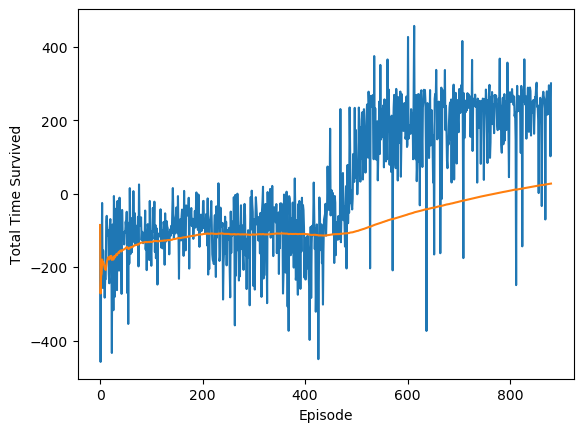

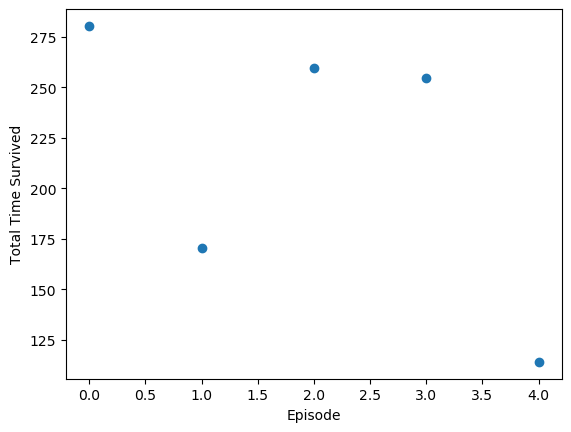

 74%|███████▍  | 370015/500000 [1:09:01<4:30:44,  8.00it/s]

Average Reward: 215.82562089531035


 76%|███████▌  | 379996/500000 [1:11:02<22:44, 87.96it/s]  

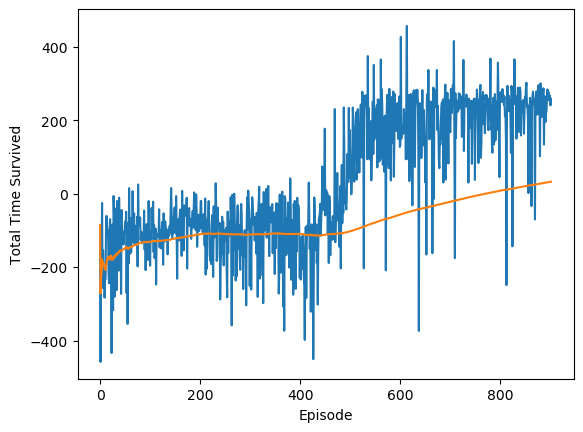

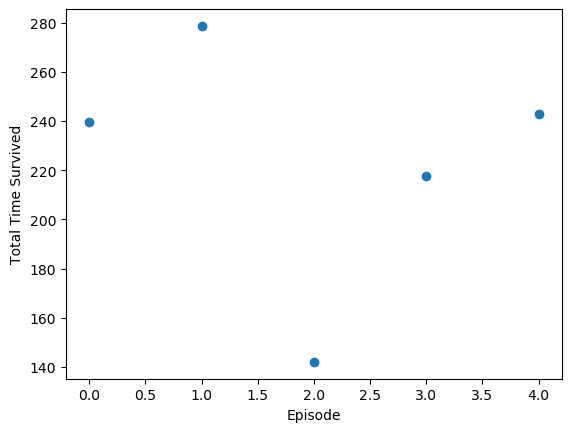

 76%|███████▌  | 380014/500000 [1:11:06<2:57:15, 11.28it/s]

Average Reward: 224.13314370424004


 78%|███████▊  | 389991/500000 [1:13:03<21:11, 86.52it/s]  

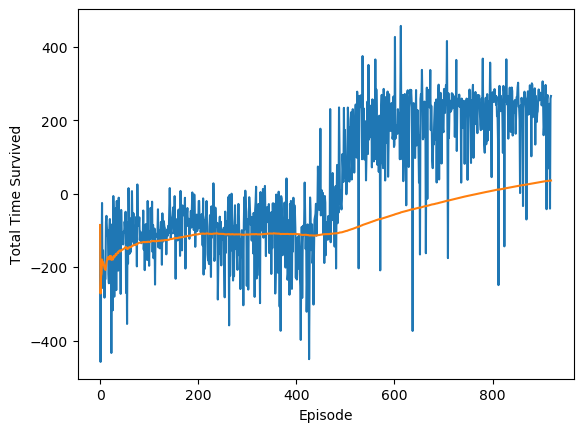

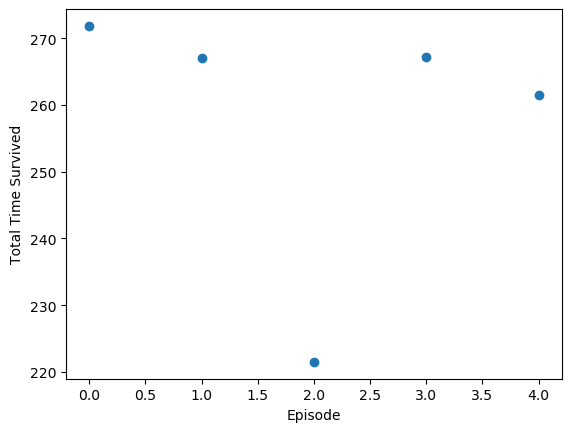

 78%|███████▊  | 390008/500000 [1:13:05<2:06:12, 14.53it/s]

Average Reward: 257.79101388017455


 80%|███████▉  | 399998/500000 [1:15:06<19:36, 84.98it/s]  

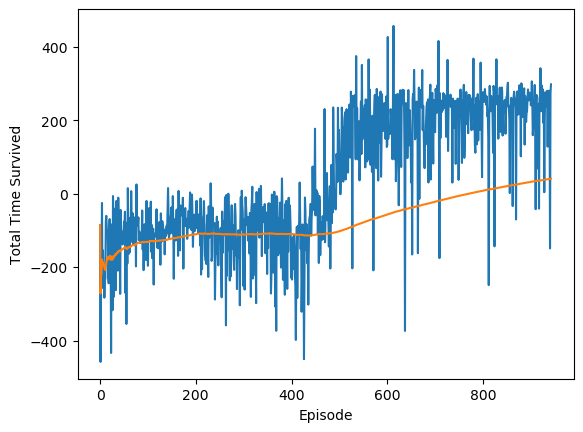

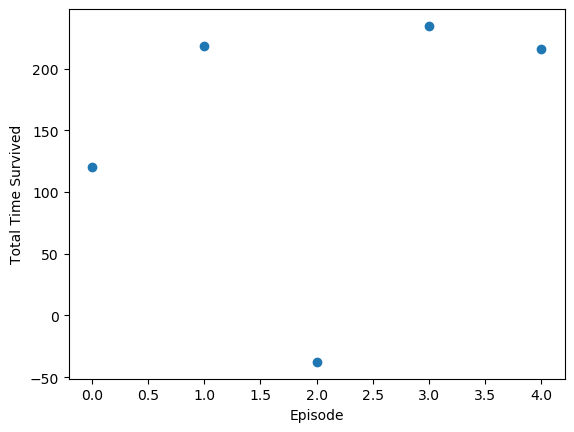

 80%|████████  | 400022/500000 [1:15:12<3:37:54,  7.65it/s]

Average Reward: 150.29351970901433


 82%|████████▏ | 409997/500000 [1:17:09<19:36, 76.50it/s]  

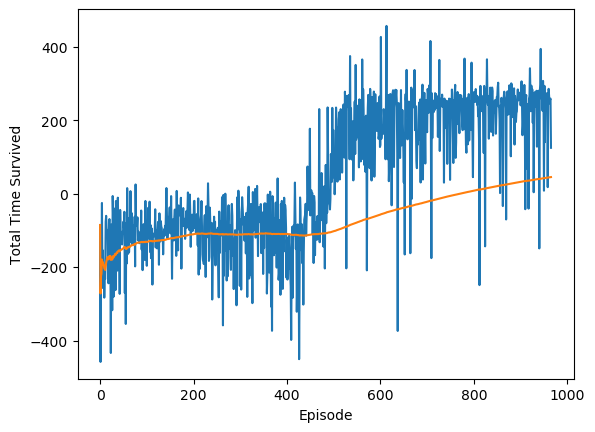

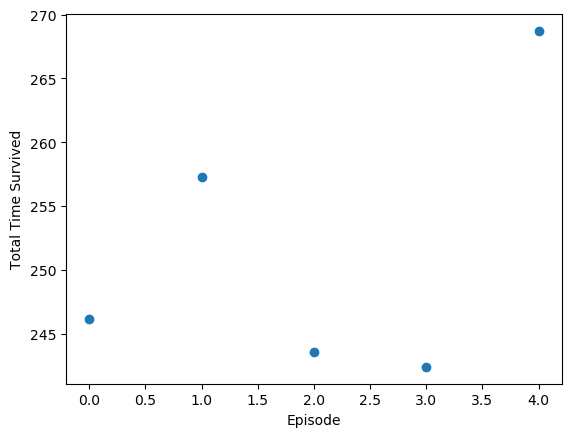

 82%|████████▏ | 410013/500000 [1:17:12<2:19:13, 10.77it/s]

Average Reward: 251.6115552340778


 84%|████████▍ | 419995/500000 [1:19:08<17:35, 75.78it/s]  

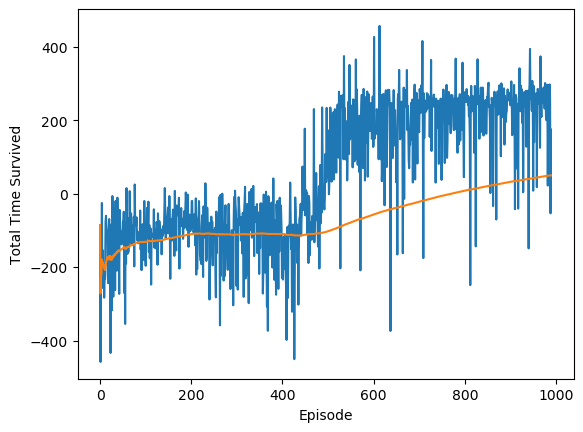

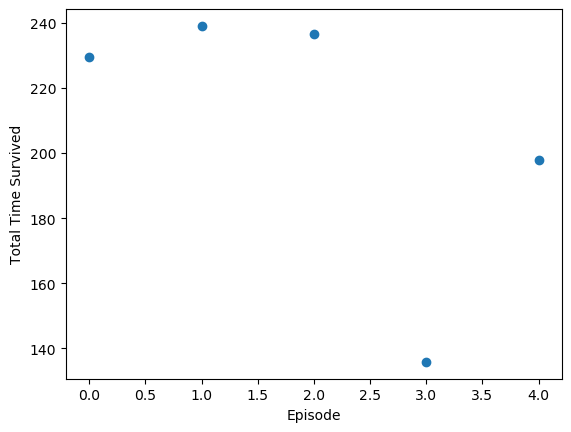

 84%|████████▍ | 420010/500000 [1:19:11<2:14:47,  9.89it/s]

Average Reward: 207.74197091004234


 86%|████████▌ | 429996/500000 [1:21:15<14:16, 81.75it/s]  

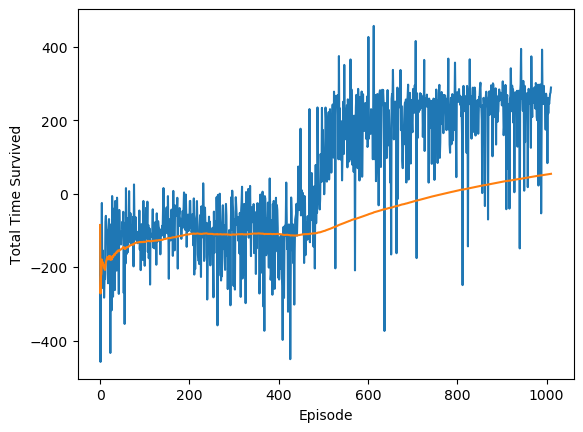

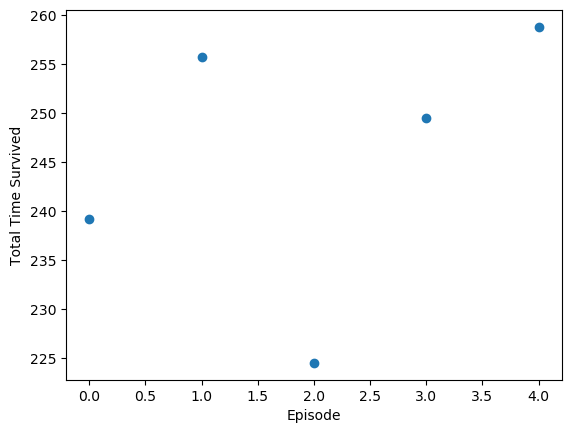

 86%|████████▌ | 430011/500000 [1:21:18<1:37:05, 12.01it/s]

Average Reward: 245.5465332502293


 88%|████████▊ | 439999/500000 [1:23:19<14:44, 67.85it/s]  

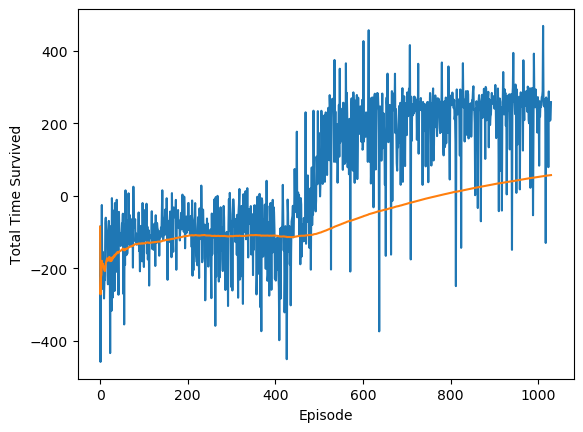

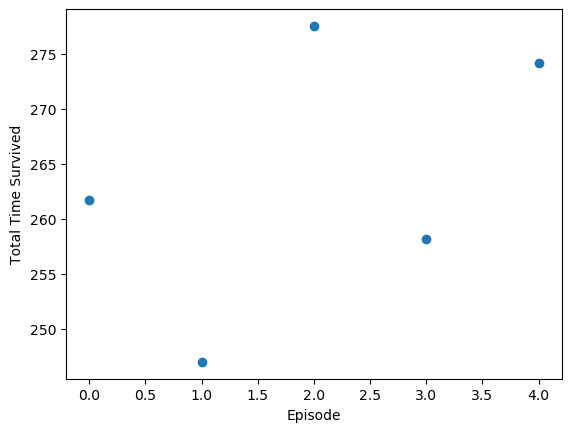

 88%|████████▊ | 440013/500000 [1:23:21<57:35, 17.36it/s]  

Average Reward: 263.70523218242636


 90%|████████▉ | 449997/500000 [1:25:21<10:08, 82.16it/s] 

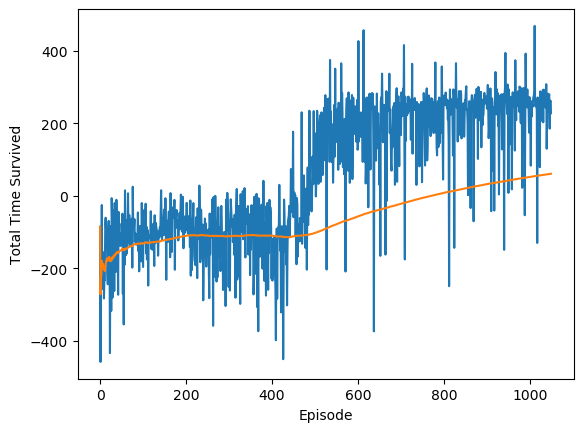

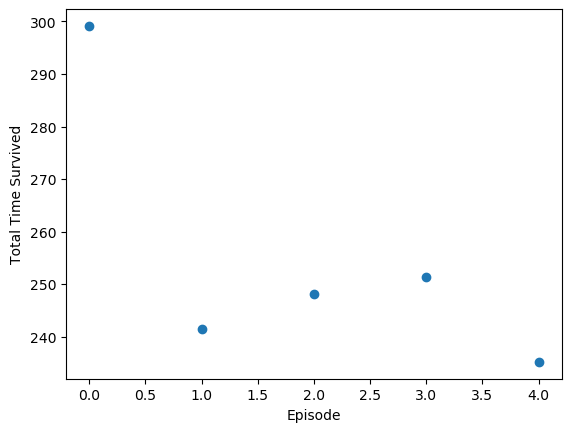

 90%|█████████ | 450006/500000 [1:25:23<56:25, 14.77it/s]

Average Reward: 255.0445743923671


 92%|█████████▏| 459996/500000 [1:27:30<09:09, 72.85it/s]

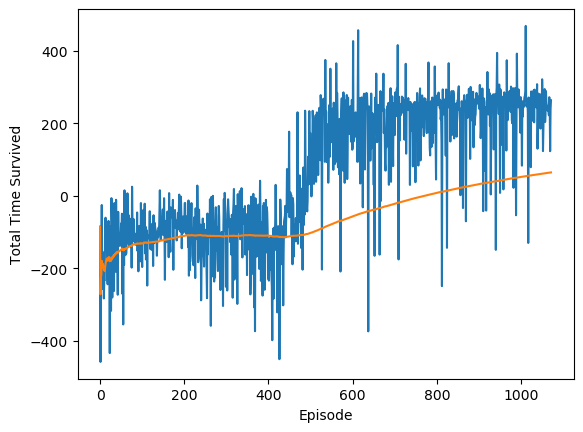

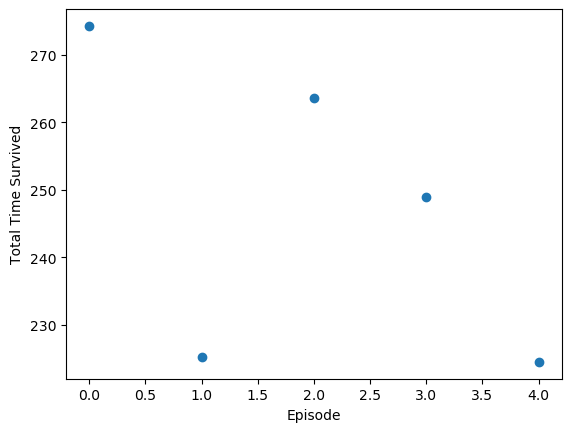

 92%|█████████▏| 460012/500000 [1:27:32<56:19, 11.83it/s]  

Average Reward: 247.26643102496246


 94%|█████████▍| 469999/500000 [1:29:38<06:56, 72.05it/s] 

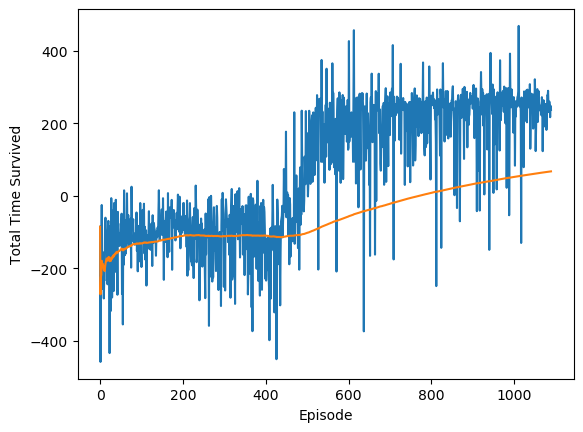

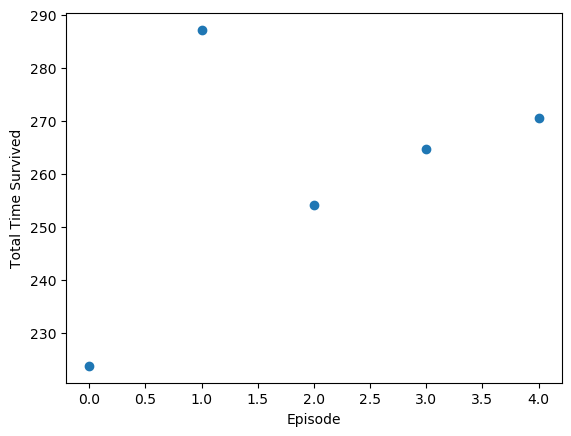

 94%|█████████▍| 470015/500000 [1:29:40<38:55, 12.84it/s]

Average Reward: 260.07838870484414


 96%|█████████▌| 479998/500000 [1:31:46<04:24, 75.69it/s] 

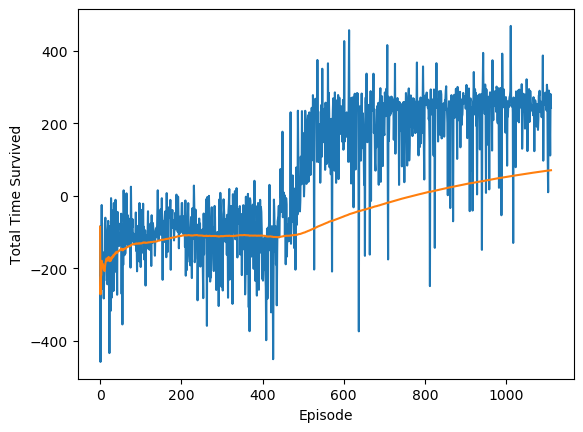

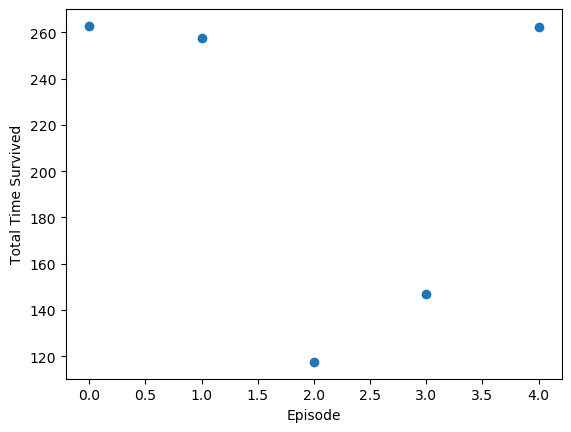

 96%|█████████▌| 480013/500000 [1:31:51<46:24,  7.18it/s]  

Average Reward: 209.48824232019834


 98%|█████████▊| 489993/500000 [1:34:00<02:10, 76.46it/s]

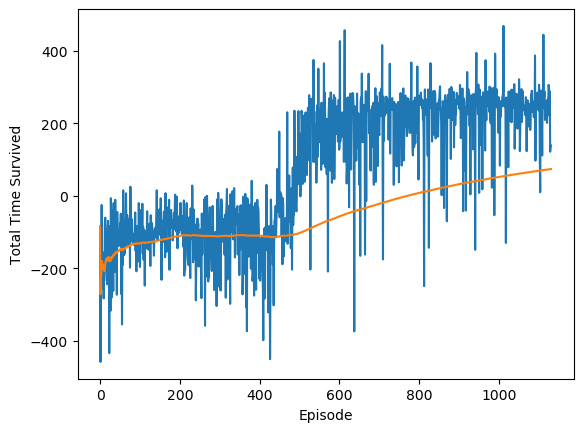

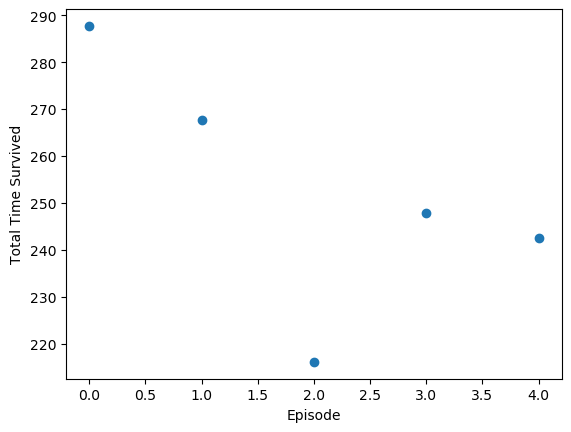

 98%|█████████▊| 490009/500000 [1:34:02<11:15, 14.80it/s]

Average Reward: 252.35168819522968


100%|█████████▉| 499995/500000 [1:36:06<00:00, 78.99it/s] 

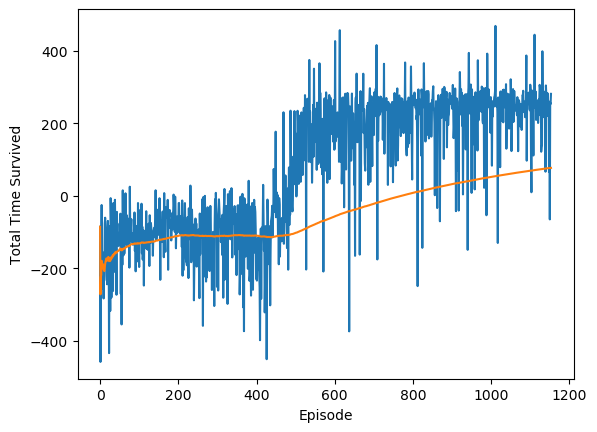

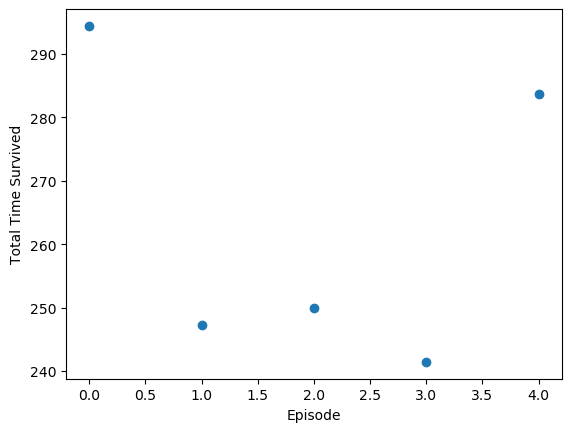

100%|██████████| 500000/500000 [1:36:08<00:00, 86.67it/s]

Average Reward: 263.32283681874935


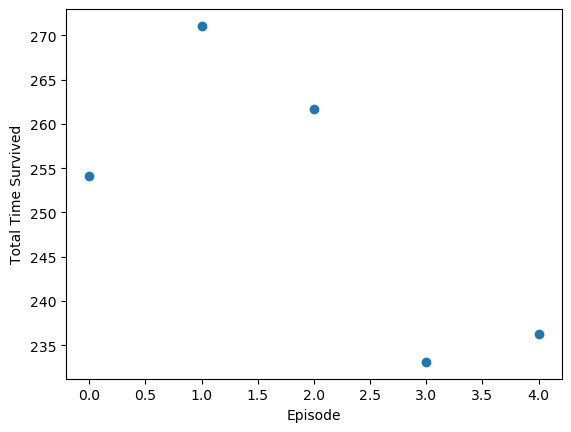

Average Reward: 251.24690641407946


In [6]:
done = False
validate_returns = []
validate_rewards = []
avg_validate_rewards = []
for time_stamp in tqdm(range(LEARNING_TIME)):
    if done:
        validate_returns.append(np.sum(validate_rewards))
        avg_validate_rewards.append(np.mean(validate_returns))
        validate_rewards.clear()
        state,_ = env.reset()
        done = False
    
    if (time_stamp + 1) % UPDATE_TIME_STAMP == 0:
        target_model.load_state_dict(train_model.state_dict())
    
    if random.random() <= epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            action_values = train_model(state).detach()
        action = int(torch.argmax(action_values.squeeze()))
    
    next_state, reward, terminated, truncated , info = env.step(action)
    validate_rewards.append(reward)
    
    done = terminated or truncated
    
    replay_buffer.append((state, action, reward, next_state, terminated and not truncated))
    state = next_state

    if(len(replay_buffer) >= BUFFER_MIN_SIZE):
        experiences =  random.sample(replay_buffer, MINI_BATCH_SIZE) 
        states = [experience[0] for experience in experiences]
        actions = [experience[1] for experience in experiences]  
        rewards = [experience[2] for experience in experiences]  
        next_states = [experience[3] for experience in experiences]  
        is_terminals = [experience[4] for experience in experiences] 
        
        action_values = train_model(np.array(states)).squeeze()
        idxs = torch.tensor(actions).long().unsqueeze(1)
        action_values = action_values.gather(1, idxs)
        
        with torch.no_grad():
            next_action_values = target_model(np.array(next_states)).detach().squeeze()
            next_action_values, _ = next_action_values.max(dim=1) 
        
        target = np.array(rewards) + GAMMA*np.array(next_action_values)*(1-np.array(is_terminals))
        target = torch.from_numpy(target).unsqueeze(1).float()
        
        loss = loss_fn(action_values, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
        
          
    epsilon = max(epsilon - DECAY, MIN_EPSILON)
    if(time_stamp + 1) % INTERVAL == 0:
        plt.plot(range(len(validate_returns)), validate_returns)   
        plt.xlabel("Episode")
        plt.ylabel("Total Time Survived")
        plt.plot(range(len(avg_validate_rewards)), avg_validate_rewards)
        plt.show() 
        torch.save(train_model, "model.pth")
        eval(False)
        
torch.save(train_model, "model.pth")
eval(True)
_ = env.reset()      

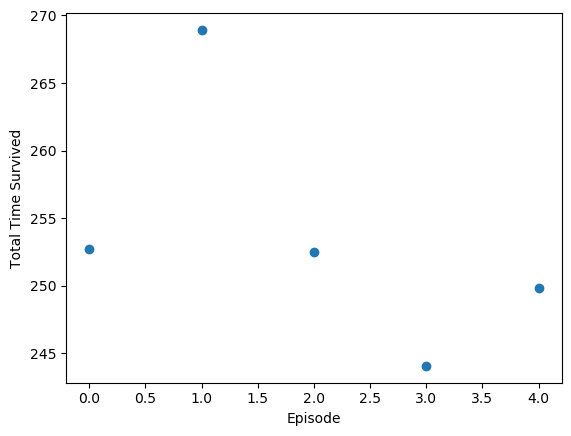

Average Reward: 253.5961795190908


In [7]:
eval(True)

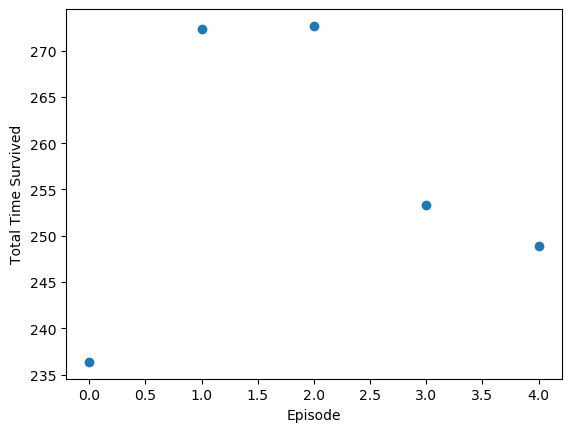

Average Reward: 256.70168192725595


In [10]:
eval(False)